In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
from sklearn.preprocessing import MinMaxScaler,StandardScaler

#모델링 모듈
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.ensemble import GradientBoostingClassifier 
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn import svm
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, average_precision_score, confusion_matrix
import shap
from imblearn.over_sampling import SMOTE

#1. data_load
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
data = pd.read_csv('train.csv')

#2. data_preprocessing
# missing D(4개 행 제거)
data.isnull().sum()
nan_data = data.dropna()
print('결측 처리 :' ,nan_data.shape)

# duplicated D(2행 제거)
nan_data[nan_data.duplicated()]
new_data = nan_data[~nan_data.duplicated()]
print('중복 처리 :',new_data.shape)

#encoding : gender-label ( Female = 0, male = 1) /  geography-onehot
le = LabelEncoder()
new_data['Gender'] = le.fit_transform(new_data["Gender"])

oe = OneHotEncoder()
oe.fit(new_data[['Geography']])
geo_csr = oe.transform(new_data[['Geography']])
csr_df = pd.DataFrame(geo_csr.toarray(), columns = oe.get_feature_names_out())
df = new_data.reset_index(drop=True)  # df 인덱스 초기화
csr_df = csr_df.reset_index(drop=True)  # csr_df 인덱스 초기화
inco_df = pd.concat([df,csr_df],axis=1)

#check
int_data = inco_df.drop(columns=['id', 'CustomerId', 'Surname','Geography'])
X = int_data.drop("Exited", axis=1)
y_true = int_data['Exited']
print('전처리 완료:',X.shape,y_true.shape)
print('----------------------------')

#4.data engineering
#tester split
X_train, X_test, y_train, y_test = train_test_split(X,y_true, stratify = y_true,test_size = 0.2, random_state= 42)
print('데이터 분리 후 크기 : ',X_train.shape, X_test.shape, y_train.shape, y_test.shape)

#minmaxscaling - 적용유무 검토 
target_features = ["CreditScore", "Age", "Balance", "EstimatedSalary"]
X_train_sc = X_train.copy()
X_test_sc = X_test.copy()

mn_sc = MinMaxScaler()
X_train_sc[target_features] = mn_sc.fit_transform(X_train[target_features])
X_test_sc[target_features] = mn_sc.transform(X_test[target_features]) #테스터는 정규화 학습 안함 

#Over Sampling
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train_sc, y_train)
print("SMOTE 적용 후 데이터 크기:", X_train_res.shape, y_train_res.shape)
print(f'original : {y_train.value_counts()}')
print(f'smote : {y_train_res.value_counts()}')

print('----------------------------')

결측 처리 : (165034, 14)
중복 처리 : (165034, 14)
전처리 완료: (165034, 12) (165034,)
----------------------------
데이터 분리 후 크기 :  (132027, 12) (33007, 12) (132027,) (33007,)
SMOTE 적용 후 데이터 크기: (208180, 12) (208180,)
original : Exited
0    104090
1     27937
Name: count, dtype: int64
smote : Exited
0    104090
1    104090
Name: count, dtype: int64
----------------------------


In [2]:
# SVM 모델
import sklearn.svm
clf = sklearn.svm.SVC(kernel='rbf',random_state=42)

clf.fit(X_train_res, y_train_res)

y_pred_svc = clf.predict(X_test_sc)

print("정확도 : ", accuracy_score(y_test, y_pred_svc))
print("f1-score : ", f1_score(y_test, y_pred_svc))
print("recall : ", recall_score(y_test, y_pred_svc))
print("예측도 : ", precision_score(y_test, y_pred_svc))
print("AUC :", average_precision_score(y_test, y_pred_svc))

정확도 :  0.797346017511437
f1-score :  0.620309927910541
recall :  0.7823596792668958
예측도 :  0.5138719082102887
AUC : 0.4480834989927629


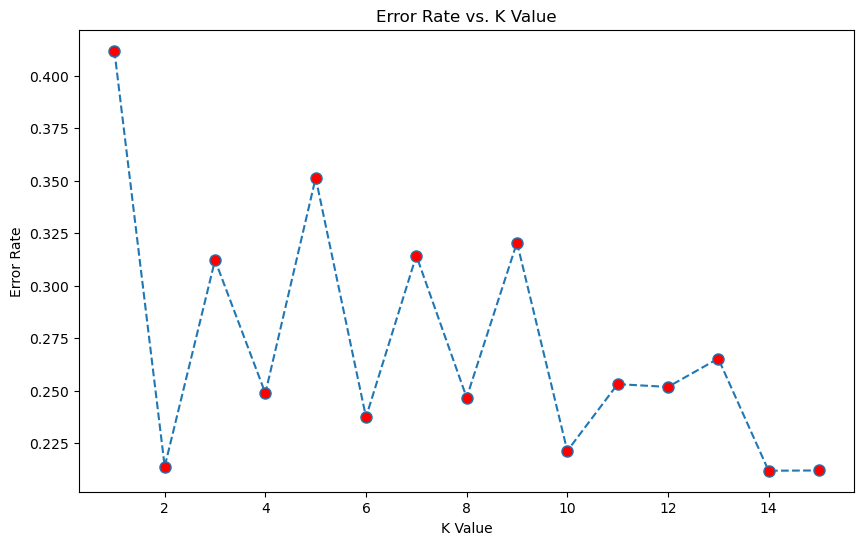

In [3]:
# KNN 모델, 추가 전처리 없을 시 K=14에서 에러율 제일 작음
error_rate = []

for i in range(1, 16):
    knn_i = KNeighborsClassifier(n_neighbors=i)
    knn_i.fit(X_train_res, y_train_res)
    y_pred_i = knn_i.predict(X_test)
    error_rate.append(np.mean(y_pred_i != y_test))

plt.figure(figsize=(10, 6))
plt.plot(range(1, 16), error_rate, marker='o', linestyle='dashed', markersize=8, markerfacecolor='red')
plt.title("Error Rate vs. K Value")
plt.xlabel("K Value")
plt.ylabel("Error Rate")
plt.show()

In [4]:
k = 2
knn = KNeighborsClassifier(n_neighbors=k)
knn.fit(X_train_res, y_train_res)
y_pred_knn = knn.predict(X_test_sc)

print("정확도 : ", accuracy_score(y_test, y_pred_knn))
print("f1-score : ", f1_score(y_test, y_pred_knn))
print("recall : ", recall_score(y_test, y_pred_knn))
print("예측도 : ", precision_score(y_test, y_pred_knn))
print("AUC :", average_precision_score(y_test, y_pred_knn))


정확도 :  0.8024055503378071
f1-score :  0.5265679442508711
recall :  0.5193298969072165
예측도 :  0.5340106007067138
AUC : 0.379033369003544


In [5]:
# 각 모델 정확도를 제외한 모든 수치가 낮아 실사용 불가, optuna를 이용한 튜닝 수행
import optuna
import itertools
import sklearn.svm
import sklearn.model_selection
from sklearn.metrics import classification_report

In [7]:
# SVC optuna 수행
def objective(trial):

    svc_c = trial.suggest_float("C", 0.01, 100, log=True)
    classifier_obj = sklearn.svm.SVC(C=svc_c, gamma="auto", random_state=42)

    score = sklearn.model_selection.cross_val_score(classifier_obj, X_train_res, y_train_res, n_jobs=-1, cv=3)
    accuracy = score.mean()
    return accuracy

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2025-02-03 11:24:25,420] A new study created in memory with name: no-name-d2087909-cf40-40bd-b578-e00f4c90bba5
[W 2025-02-03 11:25:50,291] Trial 0 failed with parameters: {'C': 0.3067281639869217} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "c:\Users\goodm\anaconda3\Lib\site-packages\optuna\study\_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\goodm\AppData\Local\Temp\ipykernel_32\2452698148.py", line 7, in objective
    score = sklearn.model_selection.cross_val_score(classifier_obj, X_train_res, y_train_res, n_jobs=-1, cv=3)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\goodm\anaconda3\Lib\site-packages\sklearn\utils\_param_validation.py", line 213, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\goodm\anaconda3\Lib\site-packages\s

KeyboardInterrupt: 

In [6]:
# 최적화된 하이퍼파라미터로 튜닝

svc_c = study.best_params['C']
model = sklearn.svm.SVC(C=svc_c, gamma="auto", random_state=42)
model.fit(X_train_res, y_train_res)

y_pred_svc_op = model.predict(X_test_sc)

print("정확도 : ", accuracy_score(y_test, y_pred_svc_op))
print("f1-score : ", f1_score(y_test, y_pred_svc_op))
print("recall : ", recall_score(y_test, y_pred_svc_op))
print("예측도 : ", precision_score(y_test, y_pred_svc_op))
print("AUC :", average_precision_score(y_test, y_pred_svc_op))

NameError: name 'study' is not defined

In [70]:
# KNN 최적화, 목적함수 정의
from sklearn.model_selection import cross_val_score

def obj_knn(trial,x,y):
    n_neighbors = trial.suggest_int('n_neighbors', 1, 30)
    metric = trial.suggest_categorical('metric', ['euclidean', 'manhattan', 'minkowski'])
    weights = trial.suggest_categorical('weights', ['uniform', 'distance'])

    model = KNeighborsClassifier(n_neighbors=n_neighbors, metric=metric, weights=weights)
    score = cross_val_score(model, x, y, n_jobs=-1, cv=10, scoring='f1_macro')
    f1_macro = np.mean(score)

    return f1_macro

study = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=42))
study.optimize(lambda trial: obj_knn(trial, X_train_res, y_train_res), n_trials = 100)

# 최적 파라미터 출력
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

# 최적 파라미터로 모델 학습
best_params = study.best_trial.params
knn_model = KNeighborsClassifier(**best_params)

[I 2025-01-31 19:52:15,687] A new study created in memory with name: no-name-327a000e-2fdd-40ee-ab6b-d672004b3daa
[I 2025-01-31 19:52:15,887] Trial 0 finished with value: 0.787216991913261 and parameters: {'n_neighbors': 12, 'metric': 'euclidean', 'weights': 'uniform'}. Best is trial 0 with value: 0.787216991913261.
[I 2025-01-31 19:52:15,992] Trial 1 finished with value: 0.8713623911643342 and parameters: {'n_neighbors': 2, 'metric': 'euclidean', 'weights': 'distance'}. Best is trial 1 with value: 0.8713623911643342.
[I 2025-01-31 19:52:16,105] Trial 2 finished with value: 0.8132242792074651 and parameters: {'n_neighbors': 25, 'metric': 'euclidean', 'weights': 'distance'}. Best is trial 1 with value: 0.8713623911643342.
[I 2025-01-31 19:52:16,209] Trial 3 finished with value: 0.8372735375874905 and parameters: {'n_neighbors': 13, 'metric': 'manhattan', 'weights': 'distance'}. Best is trial 1 with value: 0.8713623911643342.
[I 2025-01-31 19:52:16,349] Trial 4 finished with value: 0.778

Best trial:
  Value: 0.8735201058347499
  Params: 
    n_neighbors: 1
    metric: manhattan
    weights: distance


In [ ]:
# bset parmeter training
knn_model.fit(X_train_res,y_train_res)
y_pred_knn_op = knn_model.predict(X_test_sc)

print("정확도 : ", accuracy_score(y_test, y_pred_knn_op))
print("f1-score : ", f1_score(y_test, y_pred_knn_op))
print("recall : ", recall_score(y_test, y_pred_knn_op))
print("예측도 : ", precision_score(y_test, y_pred_knn_op))
print("AUC :", average_precision_score(y_test, y_pred_knn_op))


정확도 :  0.6948982994331444
f1-score :  0.3728581220013708
recall :  0.4451718494271686
예측도 :  0.32075471698113206


In [8]:
# 모델과 하이퍼파라미터 범위 정의
param_grids = {    
    'KNN': {
        'model': KNeighborsClassifier(),
        'params': {
            'n_neighbors': [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16],
            'weights': ['uniform', 'distance'],
            'metric': ['euclidean', 'manhattan', 'minkowski']
        }
    },
    'SVM': {
        'model': svm.SVC(random_state=42),
        'params': {
            'C': [0.001, 0.01, 0.1, 1, 10, 25, 50, 100, 500],
            'kernel': ['linear', 'rbf', 'poly', 'sigmod'],
            'gamma': ['auto', 'scale']
        }
    },             
}

# 결과를 저장
results = {}

In [ ]:
# 각 모델별 학습 및 평가
from sklearn.model_selection import cross_val_score, GridSearchCV
for name, model_info in param_grids.items():
    print(f"\n{name} 모델 학습 중...")

    # GridSearchCV를 통한 하이퍼파라미터 튜닝
    grid_search = GridSearchCV(
        model_info['model'],
        model_info['params'],
        cv=5,
        scoring='accuracy',
        n_jobs=-1
    )

    # 모델 학습
    grid_search.fit(X_train_res, y_train_res)

    # 5-fold cv
    cv_scores = cross_val_score(grid_search.best_estimator_, X_train_res, y_train_res, cv=5)

    # prediction
    y_pred = grid_search.predict(X_test_sc)

    # 평가 지표 계산
    results[name] = {
        'best_params': grid_search.best_params_,
        'best_score': grid_search.best_score_,
        'cv_scores_mean': cv_scores.mean(),
        'cv_scores_std': cv_scores.std(),
        'accuracy': accuracy_score(y_test, y_pred),
        'f1': f1_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred),
        'avg_precision': average_precision_score(y_test, y_pred),
        'confusion_matrix': confusion_matrix(y_test, y_pred)
    }



In [83]:
# 결과 출력
for name, result in results.items():
    print(f"\n=== {name} 모델 결과 ===")
    print(f"Best Parameters: {result['best_params']}")
    print(f"Best CV Score: {result['best_score']:.4f}")
    print(f"5-fold CV Score: {result['cv_scores_mean']:.4f} (+/- {result['cv_scores_std'] * 2:.4f})")
    print(f"Test Accuracy: {result['accuracy']:.4f}")
    print(f"F1 Score: {result['f1']:.4f}")
    print(f"Recall: {result['recall']:.4f}")
    print(f"Precision: {result['precision']:.4f}")
    print(f"Average Precision: {result['avg_precision']:.4f}")
    print("\nConfusion Matrix:")
    print(result['confusion_matrix'])


=== KNN 모델 결과 ===
Best Parameters: {'metric': 'manhattan', 'n_neighbors': 1, 'weights': 'uniform'}
Best CV Score: 0.8686
5-fold CV Score: 0.8686 (+/- 0.0105)
Test Accuracy: 0.7446
F1 Score: 0.4284
Recall: 0.4697
Precision: 0.3937
Average Precision: 0.2930

Confusion Matrix:
[[1946  442]
 [ 324  287]]

=== SVM 모델 결과 ===
Best Parameters: {'C': 500, 'gamma': 'auto', 'kernel': 'rbf'}
Best CV Score: 0.8280
5-fold CV Score: 0.8280 (+/- 0.0473)
Test Accuracy: 0.7829
F1 Score: 0.5526
Recall: 0.6579
Precision: 0.4763
Average Precision: 0.3831

Confusion Matrix:
[[1946  442]
 [ 209  402]]


CreditScore: 0.001
Gender: 0.027
Age: 0.411
Tenure: 0.001
Balance: 0.067
NumOfProducts: 0.350
HasCrCard: 0.000
IsActiveMember: 0.105
EstimatedSalary: 0.002
Geography_France: 0.000
Geography_Germany: 0.035
Geography_Spain: 0.000


<Axes: >

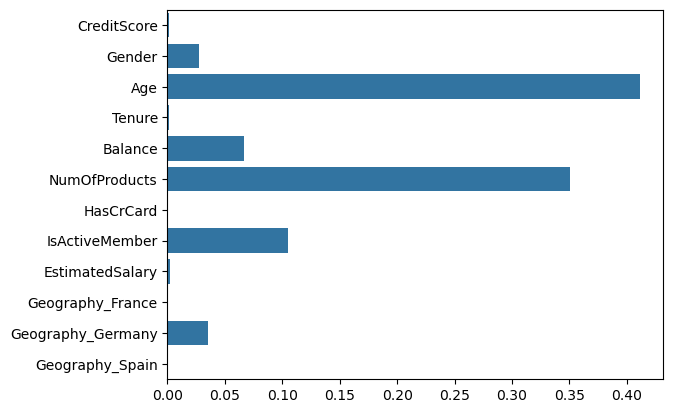

In [10]:
# Decision Tree 최적 모델에 대한 피처 임포턴스 확인, 스케일링 전 데이터 활용

from sklearn import tree

clf_dt = tree.DecisionTreeClassifier(random_state=42,
        max_depth=7,
        min_samples_split=38,
        min_samples_leaf=15,
        criterion='gini')

clf_dt.fit(X_train, y_train)

y_pred = clf_dt.predict(X_test)

for name, value in zip(X.columns.tolist(), clf_dt.feature_importances_):
    print('{0}: {1:.3f}'.format(name, value))

sns.barplot(x=clf_dt.feature_importances_, y=X.columns.tolist())

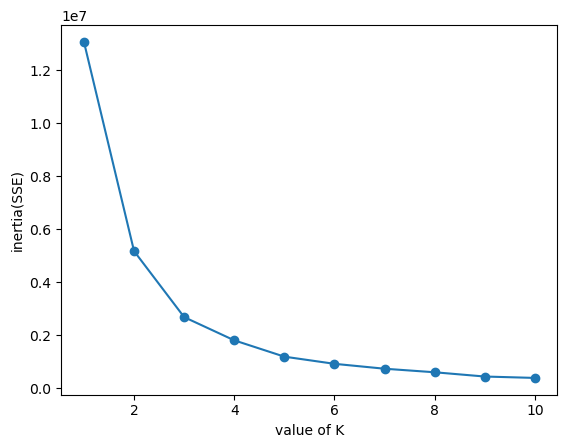

2


In [13]:
# Age, NumOfProducts 변수 기준으로 K-Means clustring 진행
from sklearn.cluster import KMeans

X_cluster = df[['Age', 'NumOfProducts', 'IsActiveMember']]

# 각 K값에 대한 오차제곱합 계산 및 시각화
SSE = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_cluster)
    SSE.append(kmeans.inertia_)

plt.plot(range(1,11), SSE, marker='o')
plt.xlabel('value of K')
plt.ylabel('inertia(SSE)')
plt.show()

diff = np.diff(SSE)
optimal_k = np.argmin(diff[1:] - diff[:1]) +2
print(optimal_k)

In [40]:
# 경사가 가장 완만해지는 K값 = 4로 사용, 1,2번 그룹이 이탈률이 상대적으로 높음
kmeans = KMeans(n_clusters=3, random_state=42)
df['Cluster'] = kmeans.fit_predict(X_cluster)
df[['Age', 'NumOfProducts','IsActiveMember', 'Cluster']].head()

cluster_analysis = df.groupby('Cluster')['Exited'].mean()
print(cluster_analysis)

Cluster
0    0.161965
1    0.268850
2    0.273495
Name: Exited, dtype: float64


In [37]:
cluster_summery = df.groupby('Cluster').mean(numeric_only=True)
cluster_summery

,id,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
Cluster,,,,,,,,,,,
0,82530.383482,1.569237e+07,655.880772,37.593863,5.047366,87.570214,1.740754,0.762401,0.504825,112182.295983,0.161965
1,82633.364807,1.569033e+07,656.860357,38.721109,4.995754,139077.518991,1.326568,0.753125,0.487418,113205.867152,0.268850
2,82333.822009,1.569312e+07,657.487819,38.812306,4.978505,100025.547322,1.338309,0.732326,0.491730,112842.455277,0.273495


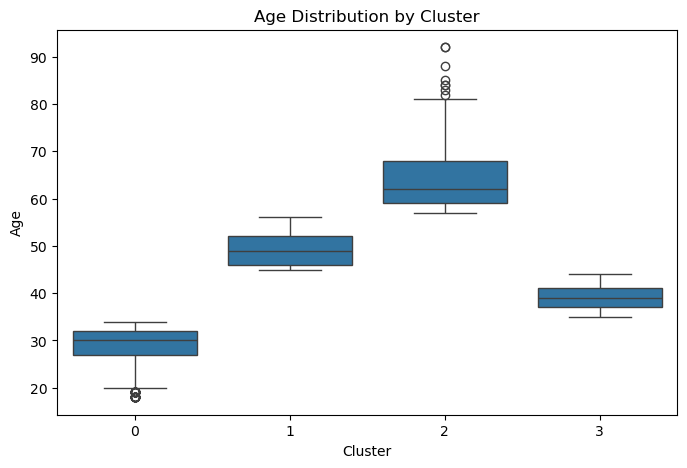

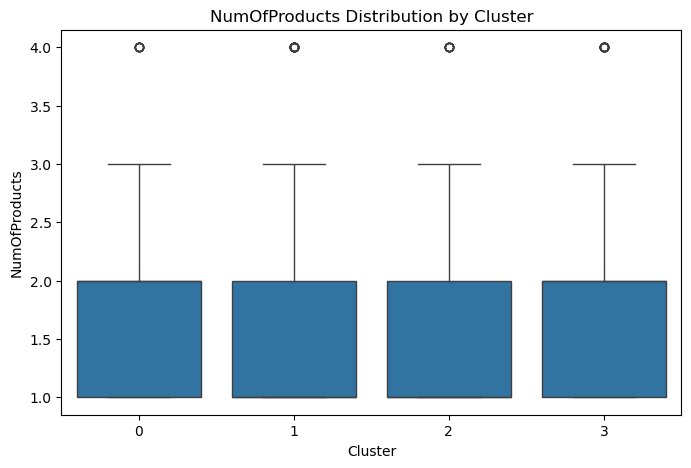

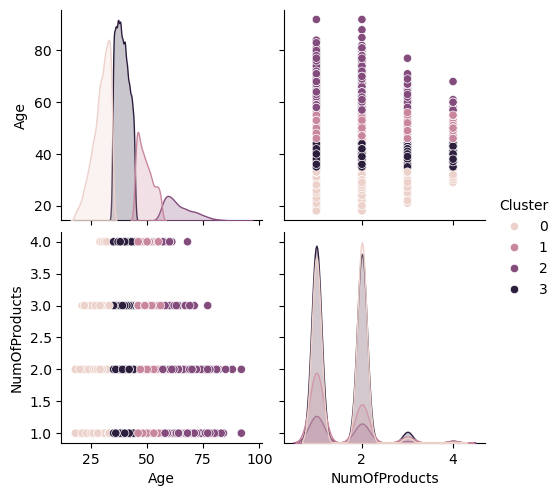

In [8]:
# 클러스터별 Age 분포
plt.figure(figsize=(8, 5))
sns.boxplot(x="Cluster", y="Age", data=df)
plt.title("Age Distribution by Cluster")
plt.show()

# 클러스터별 NumOfProducts 분포
plt.figure(figsize=(8, 5))
sns.boxplot(x="Cluster", y="NumOfProducts", data=df)
plt.title("NumOfProducts Distribution by Cluster")
plt.show()

sns.pairplot(df, hue="Cluster", vars=["Age", "NumOfProducts"])
plt.show()

- 각 그룹별 특징 정리 or 페르소나 부여
    - 0. 나이가 가장 어리고, 사용 상품이 높은 그룹 : 충성고객(이탈률이 제일 낮음)
    - 1. 나이가 2번째로 많고, 사용 상품이 제일 낮은 그룹 : 무관심 고객(곧 이탈 예정)
    - 2. 나이가 가장 많고, 사용 상품이 낮은 그룹 : 고령 고객(높은 확률로 이탈) => 상품을 많이 사용하나, 이탈률이 높은 경우에 대한 인사이트 제공
    - 3. 나이가 3번째로 많고, 사용 상품이 높은 그룹 : 주거래 고객(이탈률이 높지 않으나, 나이가 듦에 따라 이탈할 가능성이 높음)

- 각 그룹별 이탈 방지 or 이탈률 회복을 위한 전략 제시
    - 0. 사용 상품 수를 유지하거나, 지속적으로 늘릴 수 있는 프로모션 진행(학생 전용 고금리 단기 예금 + 편의점 및 교통비 혜택 추가된 체크카드)
    - 1, 2. 중장년 + 고령층 인구를 타겟으로 하는 프로모션(증여, 미술 투자 자문 제공 + 시니어라운지 및 어르신 전용 프로그램 운영 + 일정 금액 초과 주택 역모기지 출시)
    - 3. 이탈 방지를 위한 상시 프로모션 진행(직장인 전용 예적금 + 외식, 유류비, 공과금 등 각종 혜택이 많은 신용카드)

- 위에 사용 된 두 변수 이전에 신용 점수에 대한 군집화가 가능하면 EDA를 통해 고려해볼것

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, average_precision_score, roc_auc_score
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier

#obtuna
# 각 모델 정확도를 제외한 모든 수치가 낮아 실사용 불가, optuna를 이용한 튜닝 수행
# !pip install --quiet optuna

import optuna
import itertools
import sklearn.svm
import sklearn.model_selection
from sklearn.metrics import classification_report

#평가 AUC
from sklearn.metrics import roc_auc_score

# 데이터 로드 및 전처리
pd.set_option('display.max_columns', None)
df = pd.read_csv('train.csv')

nan_data = df.drop(columns=['id', 'CustomerId'])
data = nan_data[~nan_data.duplicated()]

le = LabelEncoder()
data['Gender'] = le.fit_transform(data["Gender"])

oe = OneHotEncoder()
geo_csr = oe.fit_transform(data[['Geography']])
geo_df = pd.DataFrame(geo_csr.toarray(), columns=oe.get_feature_names_out())

data = pd.concat([data.reset_index(drop=True), geo_df.reset_index(drop=True)], axis=1)
data.drop(columns=['Surname', 'Geography'], inplace=True)

X = data.drop(columns=['Exited']).reset_index(drop=True)
y = data['Exited'].reset_index(drop=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# SMOTE 적용
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

# Optuna를 이용한 하이퍼파라미터 튜닝
def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 500),
        "max_depth": trial.suggest_int("max_depth", 3, 50),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 20),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 10),
        "max_features": trial.suggest_categorical("max_features", ["sqrt", "log2"]),
    }

    rf = RandomForestClassifier(**params, class_weight="balanced", random_state=42, n_jobs=-1)
    rf.fit(X_train_res, y_train_res)
    y_prob = rf.predict_proba(X_test)[:, 1]

    best_recall = 0
    best_threshold = 0.5

    for threshold in np.arange(0.1, 0.9, 0.01):
        y_pred = (y_prob >= threshold).astype(int)
        recall = recall_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)

        # Precision ≥ 0.5 조건을 만족하면서 Recall 최대로 뽑기
        if precision >= 0.5 and recall > best_recall:
            best_recall = recall
            best_threshold = threshold

    trial.set_user_attr("best_threshold", best_threshold)

    return best_recall

# Optuna 실행
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=20, n_jobs=-1)

# 최적 threshold 값 가져오기
best_threshold = study.best_trial.user_attrs["best_threshold"]

# 최적 모델 학습
best_params = study.best_trial.params
best_model = RandomForestClassifier(**best_params, random_state=42, n_jobs=-1)
best_model.fit(X_train_res, y_train_res)

y_prob_test = best_model.predict_proba(X_test)[:, 1]

# 최종 평가
y_test_pred_final = (y_prob_test >= best_threshold).astype(int)

print("최적 하이퍼파라미터:", best_params)
print(f"최적 Threshold: {best_threshold:.2f}")
print("Accuracy:", accuracy_score(y_test, y_test_pred_final))
print("F1 Score:", f1_score(y_test, y_test_pred_final))
print("Recall:", recall_score(y_test, y_test_pred_final))
print("Precision:", precision_score(y_test, y_test_pred_final))
print("Average Precision:", average_precision_score(y_test, y_prob_test))
print("ROC AUC Score:", roc_auc_score(y_test, y_prob_test))

[I 2025-02-03 20:10:27,193] A new study created in memory with name: no-name-512c8b6b-845d-464d-a290-358867a61f44
[I 2025-02-03 20:11:40,394] Trial 6 finished with value: 0.813717067583047 and parameters: {'n_estimators': 117, 'max_depth': 11, 'min_samples_split': 7, 'min_samples_leaf': 7, 'max_features': 'log2'}. Best is trial 6 with value: 0.813717067583047.
[I 2025-02-03 20:11:40,911] Trial 9 finished with value: 0.8085624284077892 and parameters: {'n_estimators': 142, 'max_depth': 7, 'min_samples_split': 11, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 6 with value: 0.813717067583047.
[I 2025-02-03 20:11:43,537] Trial 8 finished with value: 0.8119988545246277 and parameters: {'n_estimators': 153, 'max_depth': 38, 'min_samples_split': 15, 'min_samples_leaf': 8, 'max_features': 'log2'}. Best is trial 6 with value: 0.813717067583047.
[I 2025-02-03 20:11:44,718] Trial 2 finished with value: 0.8147193585337915 and parameters: {'n_estimators': 200, 'max_depth': 10, 'min_

최적 하이퍼파라미터: {'n_estimators': 213, 'max_depth': 29, 'min_samples_split': 2, 'min_samples_leaf': 9, 'max_features': 'sqrt'}
최적 Threshold: 0.24
Accuracy: 0.7884895138804704
F1 Score: 0.6222871678302755
Recall: 0.8231672394043528
Precision: 0.5002175237100844
Average Precision: 0.7149796276274035
ROC AUC Score: 0.8847185683002241


CreditScore: 0.062
Gender: 0.029
Age: 0.319
Tenure: 0.031
Balance: 0.087
NumOfProducts: 0.255
HasCrCard: 0.006
IsActiveMember: 0.086
EstimatedSalary: 0.065
Geography_France: 0.013
Geography_Germany: 0.041
Geography_Spain: 0.006


<Axes: >

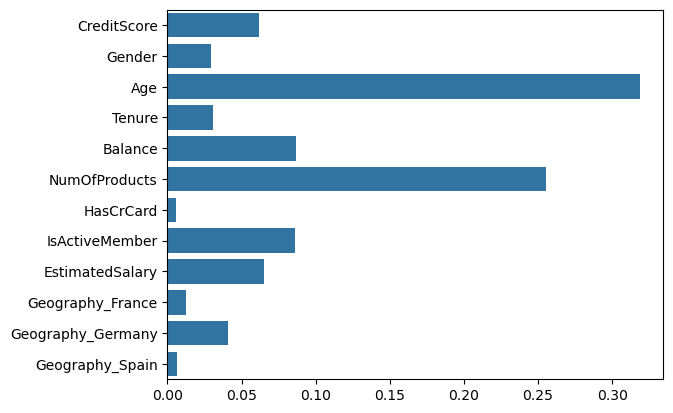

In [24]:
# 랜덤 포레스트 기반 K-Means Clustering

clf_dt = RandomForestClassifier(random_state=42,
        max_depth=29,
        min_samples_split=2,
        min_samples_leaf=9,
        n_estimators=213,
        max_features='sqrt')

clf_dt.fit(X_train, y_train)

y_pred = clf_dt.predict(X_test)

for name, value in zip(X.columns.tolist(), clf_dt.feature_importances_):
    print('{0}: {1:.3f}'.format(name, value))

sns.barplot(x=clf_dt.feature_importances_, y=X.columns.tolist())

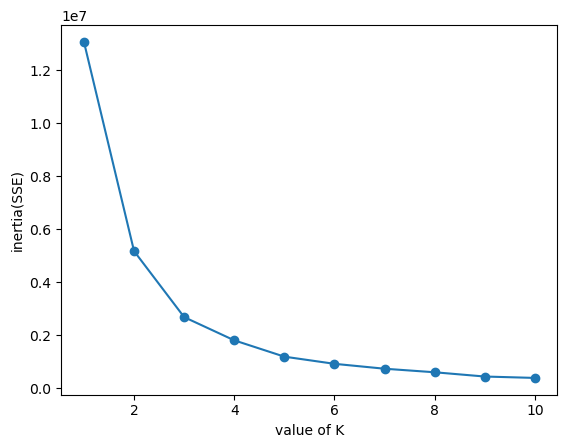

2


In [51]:
# Age, NumOfProducts, IsActiveMember 변수 기준으로 K-Means clustring 진행
from sklearn.cluster import KMeans

X_cluster = df[['Age', 'NumOfProducts', 'IsActiveMember']]

# 각 K값에 대한 오차제곱합 계산 및 시각화
SSE = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_cluster)
    SSE.append(kmeans.inertia_)

plt.plot(range(1,11), SSE, marker='o')
plt.xlabel('value of K')
plt.ylabel('inertia(SSE)')
plt.show()

diff = np.diff(SSE)
optimal_k = np.argmin(diff[1:] - diff[:1]) +2
print(optimal_k)

In [57]:
# 경사가 가장 완만해지는 K값 = 4로 사용, 1,2번 그룹이 이탈률이 상대적으로 높음
kmeans = KMeans(n_clusters=4, random_state=42)
df['Cluster'] = kmeans.fit_predict(X_cluster)
df[['Age', 'NumOfProducts','IsActiveMember' ,'Cluster']].head()

cluster_analysis = df.groupby('Cluster')['Exited'].mean()
print(cluster_analysis)

Cluster
0    0.099016
1    0.541099
2    0.280975
3    0.082649
Name: Exited, dtype: float64


In [64]:
cluster_summery = df.groupby('Cluster').mean(numeric_only=True).drop(['id', 'CustomerId'], axis=1)
cluster_summery

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
Cluster,,,,,,,,,
0,657.025899,34.151985,5.034924,51917.637852,1.597756,0.763196,0.519377,112451.580746,0.099016
1,654.773485,55.974785,4.929860,65466.302502,1.426924,0.738520,0.532869,112033.567745,0.541099
2,655.985281,41.734206,5.026507,57471.400904,1.523346,0.750416,0.457137,112771.895575,0.280975
3,657.350722,27.121307,5.038069,52091.444394,1.613530,0.752503,0.512765,112784.783856,0.082649


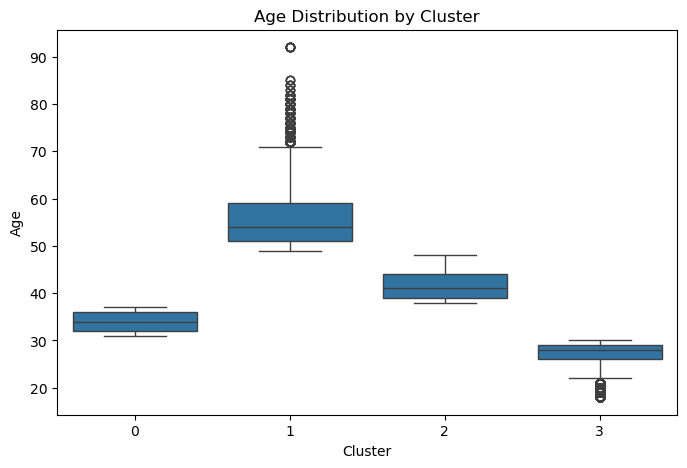

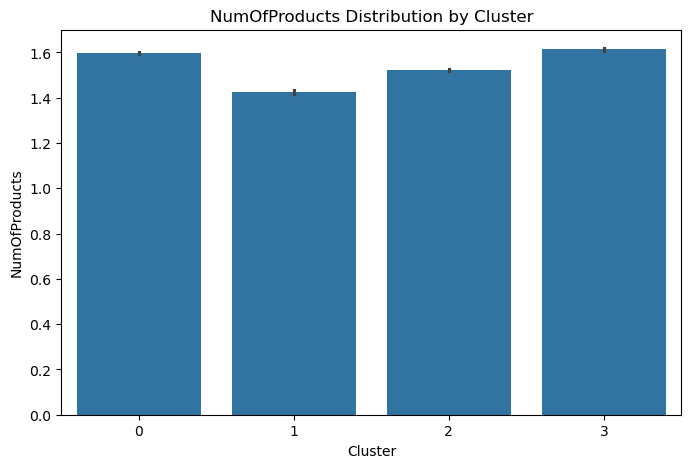

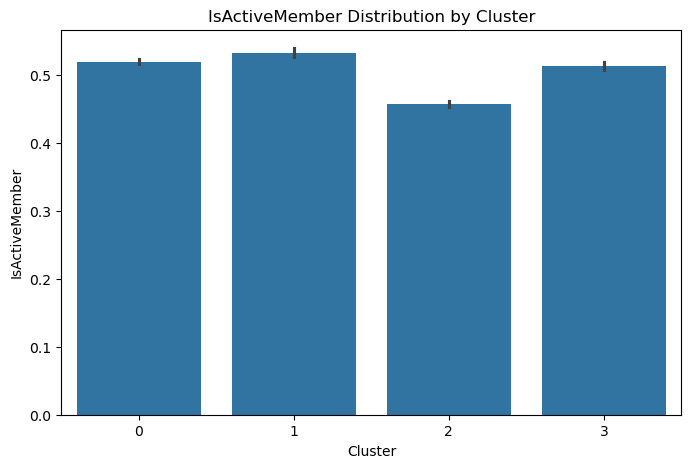

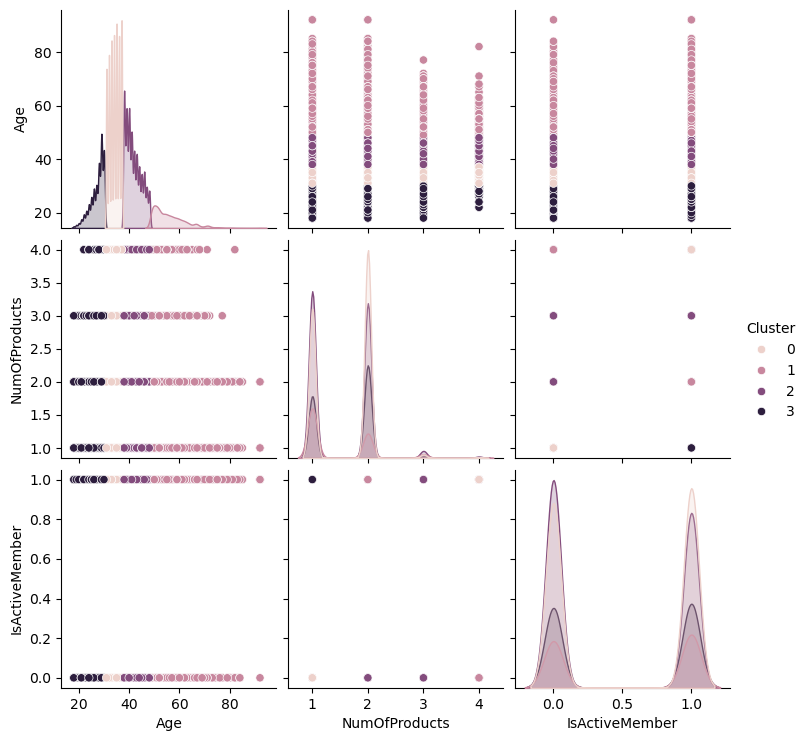

In [73]:
# 클러스터별 Age 분포
plt.figure(figsize=(8, 5))
sns.boxplot(x="Cluster", y="Age", data=df)
plt.title("Age Distribution by Cluster")
plt.show()

# 클러스터별 NumOfProducts 분포
plt.figure(figsize=(8, 5))
sns.barplot(x="Cluster", y="NumOfProducts", data=df)
plt.title("NumOfProducts Distribution by Cluster")
plt.show()

# 클러스터별 IsActiveMember 분포
plt.figure(figsize=(8, 5))
sns.barplot(x="Cluster", y="IsActiveMember", data=df)
plt.title("IsActiveMember Distribution by Cluster")
plt.show()



- 각 그룹별 특징 정리 or 페르소나 부여
    - 0. 나이가 가장 어리고, 사용 상품이 높은 그룹 : 충성고객(이탈률이 제일 낮음)
    - 1. 나이가 2번째로 많고, 사용 상품이 제일 낮은 그룹 : 무관심 고객(곧 이탈 예정)
    - 2. 나이가 가장 많고, 사용 상품이 낮은 그룹 : 고령 고객(높은 확률로 이탈) => 상품을 많이 사용하나, 이탈률이 높은 경우에 대한 인사이트 제공
    - 3. 나이가 3번째로 많고, 사용 상품이 높은 그룹 : 주거래 고객(이탈률이 높지 않으나, 나이가 듦에 따라 이탈할 가능성이 높음)

- 각 그룹별 이탈 방지 or 이탈률 회복을 위한 전략 제시
    - 0. 사용 상품 수를 유지하거나, 지속적으로 늘릴 수 있는 프로모션 진행(학생 전용 고금리 단기 예금 + 편의점 및 교통비 혜택 추가된 체크카드)
    - 1, 2. 중장년 + 고령층 인구를 타겟으로 하는 프로모션(증여, 미술 투자 자문 제공 + 시니어라운지 및 어르신 전용 프로그램 운영 + 일정 금액 초과 주택 역모기지 출시)
    - 3. 이탈 방지를 위한 상시 프로모션 진행(직장인 전용 예적금 + 외식, 유류비, 공과금 등 각종 혜택이 많은 신용카드)